
### Описание задачи
1. Требуется предобработать собранные данные, разделить адресс на части: адрес, шоссе, км.
2. Из названия выбираем тип домов, определяем их в новый столбик.
3. Очищаем данные от лишних символов: знак рубля, сот. , м2.
4. Группируем предложения по площади участка, дома и стоимости.
5. Подготовить БД к работе в DATALENS.yandex.cloud.

### Описание БД (До)
1. title - описание лота.
2. price - стоимость лота.
3. house_area - площадь дома.
4. land_area - площадь участка.
5. location - описание локации, присутсвует пробелма в виде отсутсвия разделения между блоком адреса и шоссе.
6. date_posted - дата публикации.

### Описание БД (После)

1. title - описание лота.
2. price - стоимость лота.
3. house_area - площадь дома.
4. land_area - площадь участка.
5. date_posted - дата публикации.
6. address - адрес.
7. highway - шоссе.
8. km - км на трассе.
9. type - тип строения.
10.  house_area_group - распределение по площади дома.
11.  land_area_group - распределение по площади участка.
12.  price_per_m2 - стоимость за м2.
13.  price_per_m2_group - распределение по стоимости м2.

In [1]:
import pandas as pd
import re
import concurrent.futures
from geopy.geocoders import Nominatim
import time
from datetime import datetime, timedelta
import re
from dateutil.relativedelta import relativedelta
import dateparser
import calendar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Простая загрузка
df = pd.read_csv('Edu_DF_HOME-MO_before.csv')

In [4]:
# Смотрим, что получилось
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4899 entries, 0 to 4898
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        4899 non-null   object
 1   price        4899 non-null   object
 2   house_area   4899 non-null   object
 3   land_area    4899 non-null   object
 4   location     4899 non-null   object
 5   date_posted  4899 non-null   object
dtypes: object(6)
memory usage: 229.8+ KB


In [5]:
# Список известных шоссе, дополняем его из списка ниже (Уже добавлены)
highways = [
    "Пятницкое шоссе", "Калужское шоссе", "Волоколамское шоссе",
    "Новорязанское шоссе", "Щёлковское шоссе", "Горьковское шоссе",
    "Можайское шоссе", "Симферопольское шоссе", "Минское шоссе",
    "Рублёво-Успенское шоссе", "Ярославское шоссе", "Новорижское шоссе",
    "Киевское шоссе", "Дмитровское шоссе", "Носовихинское шоссе", "Рогачёвское шоссе", "Варшавское шоссе",
    "Ленинградское шоссе", "Егорьевское шоссе", "Новокаширское шоссе", "Фряновское шоссе", "Каширское шоссе", 
    "Быковское шоссе", "Рязанское шоссе", "Новосходненское шоссе", "Куркинское шоссе", "Боровское шоссе",
    "Осташковское шоссе", "Ильинское шоссе", "Алтуфьевское шоссе", "Егорьевское шоссе"
]

In [6]:
#  Функция для разделения location с учетом известных шоссе
def split_location(location):
    # Пробуем найти совпадение с каждым шоссе из списка
    for highway in highways:
        if highway in location:
            # Разделяем строку по шоссе
            address = location.split(highway)[0].strip()
            km_match = re.search(r'(\d+)\s*км', location)
            km = km_match.group(1) if km_match else None
            return address, highway, km
    # Если не нашли совпадений, возвращаем исходные данные
    return location, None, None

In [7]:
# Применяем функцию к столбцу location
df[['address', 'highway', 'km']] = df['location'].apply(
    lambda x: pd.Series(split_location(x))
)

In [8]:
# Фильтруем строки, где столбец 'highway' равен None
missing_highway_df = df[df['highway'].isna()]

In [9]:
# Отображаем только столбец 'address' для этих строк
missing_highway_addresses = missing_highway_df[['address']]

In [10]:
#Вручную собираем значения шоссе и пополняем список известных шоссе. При значении 
missing_highway_addresses.value_counts()

address                                                                                    
,                                                                                              15
СНТ Весна                                                                                       5
Москва, СНТ Утро, 30                                                                            1
Москва, СНТ Хлыново, 77                                                                         1
Московская обл., ДНТ Лесная Поляна                                                              1
Московская обл., Дмитровский муниципальный округ, территория Новая Поповка, 1                   1
Московская обл., Можайский муниципальный округ, ДНП Можайское Раздолье, 342                     1
Московская обл., Можайский муниципальный округ, коттеджный пос. Захарьино-3, 40                 1
Московская обл., Одинцовский г.о., КП Раздоры-2                                                 1
Москва, Новомосковский адм

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4899 entries, 0 to 4898
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        4899 non-null   object
 1   price        4899 non-null   object
 2   house_area   4899 non-null   object
 3   land_area    4899 non-null   object
 4   location     4899 non-null   object
 5   date_posted  4899 non-null   object
 6   address      4899 non-null   object
 7   highway      4839 non-null   object
 8   km           4796 non-null   object
dtypes: object(9)
memory usage: 344.6+ KB


In [12]:
df.head()

,title,price,house_area,land_area,location,date_posted,address,highway,km
0,Дом 154 м² на участке 7 сот.,10 999 000 ₽,154 м²,7 сот.,"д. ЕремеевоПятницкое шоссе, 27 км",Вчера,д. Еремеево,Пятницкое шоссе,27
1,Дом 150 м² на участке 7 сот.,10 900 000 ₽,150 м²,7 сот.,"ТроицкКалужское шоссе, 24 км",2 недели назад,Троицк,Калужское шоссе,24
2,"Дом 158,6 м² на участке 5,9 сот.",19 500 000 ₽,"158,6 м²","5,9 сот.",коттеджный пос. Берег ПесочнойВолоколамское шо...,6 июля 19:18,коттеджный пос. Берег Песочной,Волоколамское шоссе,31
3,Дача 55 м² на участке 7 сот.,3 350 000 ₽,55 м²,7 сот.,загородный комплекс Зелёный кварталЕгорьевское...,22 июня 15:22,загородный комплекс Зелёный квартал,Егорьевское шоссе,52
4,"Дом 141 м² на участке 6,7 сот.",21 800 000 ₽,141 м²,"6,7 сот.","СНТ КупавнаНосовихинское шоссе, 19 км",10 июля 20:06,СНТ Купавна,Носовихинское шоссе,19


In [13]:
# Любопытства ради смотрим сколько шоссе и где по группам 
highway_counts = df.groupby('highway').size()

In [14]:
highway_counts

highway
Алтуфьевское шоссе          16
Боровское шоссе             38
Быковское шоссе             25
Варшавское шоссе           129
Волоколамское шоссе        339
Горьковское шоссе          152
Дмитровское шоссе          250
Егорьевское шоссе          343
Ильинское шоссе             34
Калужское шоссе            180
Каширское шоссе            120
Киевское шоссе             225
Куркинское шоссе            11
Ленинградское шоссе         80
Минское шоссе              221
Можайское шоссе            103
Новокаширское шоссе        400
Новорижское шоссе           82
Новорязанское шоссе        356
Новосходненское шоссе        7
Носовихинское шоссе        200
Осташковское шоссе           6
Пятницкое шоссе            235
Рогачёвское шоссе           98
Рублёво-Успенское шоссе    127
Рязанское шоссе            100
Симферопольское шоссе      426
Фряновское шоссе            68
Щёлковское шоссе           111
Ярославское шоссе          357
dtype: int64

In [15]:
# Удаляем старый столбик сшитых данных
df = df.drop(columns=['location'])

In [16]:
# Удаляем символ ₽ и преобразуем столбец 'price' в числовое значение
df['price'] = df['price'].replace({' ₽': '', ' ' : ''}, regex=True).astype(float)

In [17]:
# Удаляем символ 'м²' и заменяем запятую на точку, чтобы преобразовать в числовое значение
df['house_area'] = df['house_area'].replace({' м²': '', ' ' : ''}, regex=True)
df['house_area'] = df['house_area'].str.replace(',', '.').astype(float)


In [18]:
# Удаляем символ 'сот' и заменяем запятую на точку для столбца 'land_area'
df['land_area'] = df['land_area'].replace({' сот.': '', ' ' : ''}, regex=True)

# Заменяем все строки, которые не являются числовыми, на NaN
df['land_area'] = pd.to_numeric(df['land_area'], errors='coerce')

In [19]:
# Список типов, которые могут быть в строках
types = ['Дом', 'Дача', 'Коттедж', 'Таунхаус']

In [20]:
# Функция для извлечения типа предложения из столбца 'title'
def extract_type_from_values(description):
    for t in types:
        if t in description:
            return t
    return "Неизвестно"  # если тип не найден


In [21]:
# Применяем функцию к столбцу 'title'
df['type'] = df['title'].apply(extract_type_from_values)

In [22]:
df.head()

,title,price,house_area,land_area,date_posted,address,highway,km,type
0,Дом 154 м² на участке 7 сот.,10999000.0,154.0,7.0,Вчера,д. Еремеево,Пятницкое шоссе,27,Дом
1,Дом 150 м² на участке 7 сот.,10900000.0,150.0,7.0,2 недели назад,Троицк,Калужское шоссе,24,Дом
2,"Дом 158,6 м² на участке 5,9 сот.",19500000.0,158.6,NaN,6 июля 19:18,коттеджный пос. Берег Песочной,Волоколамское шоссе,31,Дом
3,Дача 55 м² на участке 7 сот.,3350000.0,55.0,7.0,22 июня 15:22,загородный комплекс Зелёный квартал,Егорьевское шоссе,52,Дача
4,"Дом 141 м² на участке 6,7 сот.",21800000.0,141.0,NaN,10 июля 20:06,СНТ Купавна,Носовихинское шоссе,19,Дом


In [23]:
df.head(20)

,title,price,house_area,land_area,date_posted,address,highway,km,type
0,Дом 154 м² на участке 7 сот.,10999000.0,154.0,7.0,Вчера,д. Еремеево,Пятницкое шоссе,27,Дом
1,Дом 150 м² на участке 7 сот.,10900000.0,150.0,7.0,2 недели назад,Троицк,Калужское шоссе,24,Дом
2,"Дом 158,6 м² на участке 5,9 сот.",19500000.0,158.6,NaN,6 июля 19:18,коттеджный пос. Берег Песочной,Волоколамское шоссе,31,Дом
3,Дача 55 м² на участке 7 сот.,3350000.0,55.0,7.0,22 июня 15:22,загородный комплекс Зелёный квартал,Егорьевское шоссе,52,Дача
4,"Дом 141 м² на участке 6,7 сот.",21800000.0,141.0,NaN,10 июля 20:06,СНТ Купавна,Носовихинское шоссе,19,Дом
5,Дом 22 м² на участке 6 сот.,600000.0,22.0,6.0,1 час назад,"Дмитров, СНТ Горняк",Дмитровское шоссе,46,Дом
6,Дом 180 м² на участке 8 сот.,8200000.0,180.0,8.0,23 апреля 14:12,СНТ Химик-5А,Новорязанское шоссе,64,Дом
7,Дом 120 м² на участке 4 сот.,5945000.0,120.0,4.0,17 июля 10:37,д. Маврино,Калужское шоссе,37,Дом
8,Дом 135 м² на участке 7 сот.,11500000.0,135.0,7.0,7 дней назад,Воскресенское,Калужское шоссе,11,Дом
9,"Дом 240 м² на участке 12,7 сот.",19795000.0,240.0,NaN,7 дней назад,коттеджный пос. Семибратское-1,Новорязанское шоссе,80,Дом


In [24]:
# Создаем столбец с группами по площади дома с новыми бинами
house_area_bins = [0, 60, 90, 120, 150, 180, 210, 240, 300, float('inf')]  # Бины для площади домов
house_area_labels = ['0-60 м²', '60-90 м²', '90-120 м²', '120-150 м²', '150-180 м²', '180-210 м²', '210-240 м²', '240-300 м²', '300+ м²']  # Названия групп
df['house_area_group'] = pd.cut(df['house_area'], bins=house_area_bins, labels=house_area_labels, right=False)


In [25]:
# Создаем столбец с группами по площади участка
land_area_bins = [0, 3, 6, 9, 12, 15, 17, float('inf')]  # Бины для площади участка
land_area_labels = ['0-3 сотки', '3-6 соток', '6-9 соток', '9-12 соток', '12-15 соток', '15-17 соток', '17+ соток']  # Названия групп
df['land_area_group'] = pd.cut(df['land_area'], bins=land_area_bins, labels=land_area_labels, right=False)


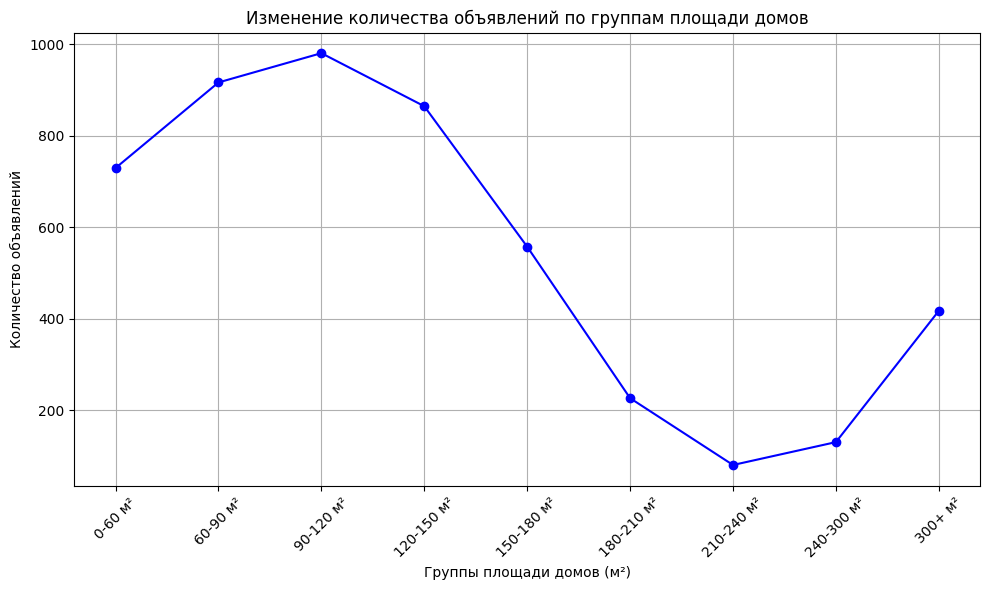

In [26]:
# Подсчитываем количество объявлений по группам площади дома
house_area_counts = df['house_area_group'].value_counts().sort_index()

# Строим график
plt.figure(figsize=(10, 6))
house_area_counts.plot(kind='line', marker='o', linestyle='-', color='b')

# Настройка графика
plt.title('Изменение количества объявлений по группам площади домов')
plt.xlabel('Группы площади домов (м²)')
plt.ylabel('Количество объявлений')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

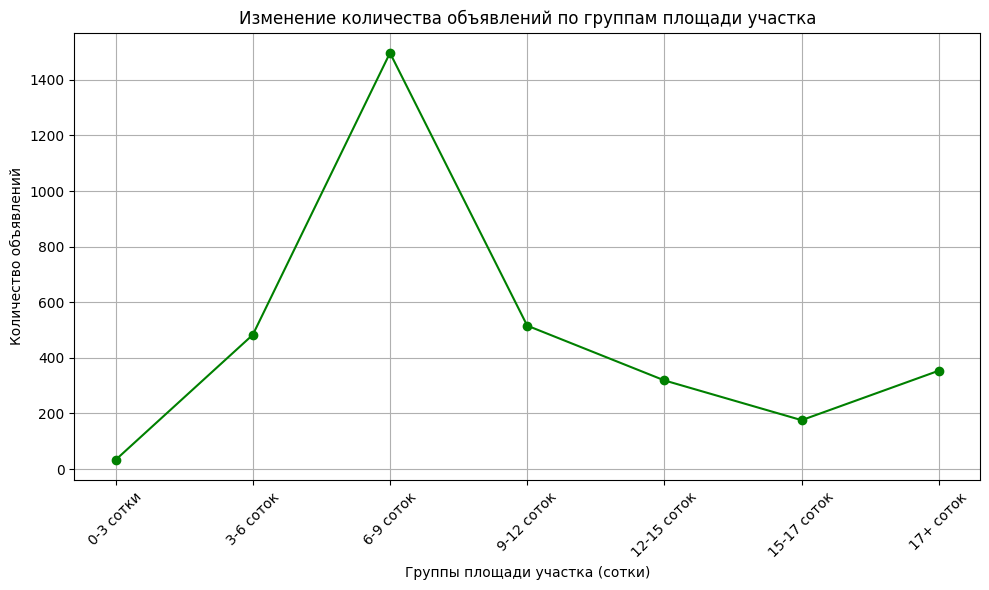

In [27]:
# Подсчитываем количество объявлений по группам площади участка
land_area_counts = df['land_area_group'].value_counts().sort_index()

# Строим график
plt.figure(figsize=(10, 6))
land_area_counts.plot(kind='line', marker='o', linestyle='-', color='g')

# Настройка графика
plt.title('Изменение количества объявлений по группам площади участка')
plt.xlabel('Группы площади участка (сотки)')
plt.ylabel('Количество объявлений')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

In [28]:
# Рассчитываем стоимость за м²
df['price_per_m2'] = df['price'] / df['house_area']

In [29]:
# Определяем интервалы стоимости за м² с шагом 10 000
price_bins = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000,
              150000, 200000, 250000, 300000, float('inf')]  # до 300 000 и более

# Создаем метки для стоимости
price_labels = ['0-10k', '10k-20k', '20k-30k', '30k-40k', '40k-50k', '50k-60k', '60k-70k', '70k-80k', '80k-90k', '90k-100k',
                '100k-150k', '150k-200k', '200k-250k', '250k-300k', '300k+']

# Группируем по стоимости за м²
df['price_per_m2_group'] = pd.cut(df['price_per_m2'], bins=price_bins, labels=price_labels, right=False)

In [30]:
# Подсчитываем количество объявлений в каждой группе
price_counts = df['price_per_m2_group'].value_counts().sort_index()

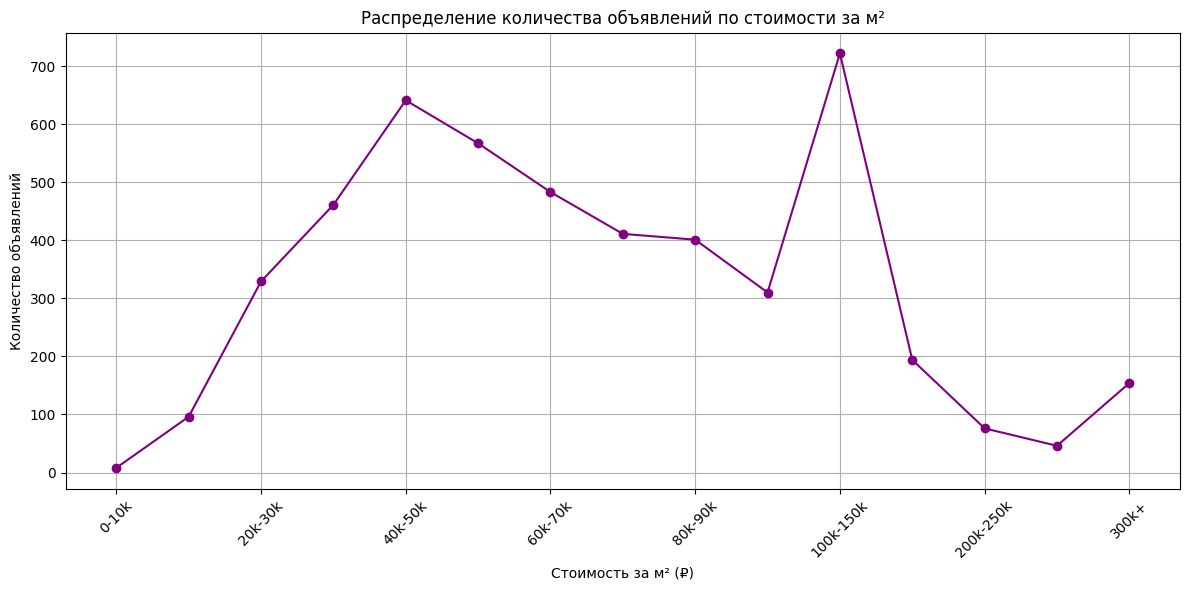

In [31]:
# Строим график
plt.figure(figsize=(12, 6))
price_counts.plot(kind='line', marker='o', linestyle='-', color='purple')

# Настройка графика
plt.title('Распределение количества объявлений по стоимости за м²')
plt.xlabel('Стоимость за м² (₽)')
plt.ylabel('Количество объявлений')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

In [32]:
df

,title,price,house_area,land_area,date_posted,address,highway,km,type,house_area_group,land_area_group,price_per_m2,price_per_m2_group
0,Дом 154 м² на участке 7 сот.,10999000.0,154.0,7.0,Вчера,д. Еремеево,Пятницкое шоссе,27,Дом,150-180 м²,6-9 соток,71422.077922,70k-80k
1,Дом 150 м² на участке 7 сот.,10900000.0,150.0,7.0,2 недели назад,Троицк,Калужское шоссе,24,Дом,150-180 м²,6-9 соток,72666.666667,70k-80k
2,"Дом 158,6 м² на участке 5,9 сот.",19500000.0,158.6,NaN,6 июля 19:18,коттеджный пос. Берег Песочной,Волоколамское шоссе,31,Дом,150-180 м²,NaN,122950.819672,100k-150k
3,Дача 55 м² на участке 7 сот.,3350000.0,55.0,7.0,22 июня 15:22,загородный комплекс Зелёный квартал,Егорьевское шоссе,52,Дача,0-60 м²,6-9 соток,60909.090909,60k-70k
4,"Дом 141 м² на участке 6,7 сот.",21800000.0,141.0,NaN,10 июля 20:06,СНТ Купавна,Носовихинское шоссе,19,Дом,120-150 м²,NaN,154609.929078,150k-200k
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4894,Дом 85 м² на участке 4 сот.,5345000.0,85.0,4.0,3 недели назад,пос. Рогово,Варшавское шоссе,52,Дом,60-90 м²,3-6 соток,62882.352941,60k-70k
4895,"Дом 150,8 м² на участке 7,2 сот.",18900000.0,150.8,NaN,2 недели назад,садовое товарищество Холмы-2,Пятницкое шоссе,30,Дом,150-180 м²,NaN,125331.564987,100k-150k
4896,Дача 19 м² на участке 6 сот.,1249000.0,19.0,6.0,16 апреля 21:47,СНТ Печатник,Рогачёвское шоссе,66,Дача,0-60 м²,6-9 соток,65736.842105,60k-70k
4897,Коттедж 200 м² на участке 18 сот.,13000000.0,200.0,18.0,30 июля 14:04,с. Троицкое,Симферопольское шоссе,36,Коттедж,180-210 м²,17+ соток,65000.000000,60k-70k


In [34]:
# Сохранение в CSV
df.to_csv('Edu_DF_HOME-MO_after.csv', index=False, encoding='utf-8')